# Recommendation Systems 

This notebook is also available on github: https://github.com/swiatej/ds4/blob/main/recommendation_systems.ipynb

This notebook is a report for an assignment for recommender systems for CA4015 Advanced Machine Learning.
The data is available here: https://grouplens.org/datasets/hetrec-2011/

This notebook spans three recommender systems: using user similarities, using clustering, and using softmax neural networks.
I first go through data cleaning and data exploration (mostly using various bar plots and histograms), and then train various recommender systems.

In [157]:
# Imports (this is for all models)
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
import sys
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)
from datetime import datetime
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install scikit.surprise
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import pickle
from sys import exc_info
import ast
# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols



In [403]:
# @title Load the  data.

# Load each data set.

import pandas as pd
import numpy as np
# Information about artists
artists_columns = ['artist_id', 'name', 'url', 'pictureurl']
artists = pd.read_csv(
    'lastfm/artists.tsv', sep='\t',names=artists_columns)

tags_columns = ['tag_id', 'tag_value']
tags = pd.read_csv(
    'lastfm/tags.tsv', sep='\t',names = tags_columns, encoding='latin-1')

user_artists_columns = [ 'user_id','artist_id','weight'
]

user_artists = pd.read_csv(
    'lastfm/user_artists.tsv',sep='\t',names=user_artists_columns, encoding='latin-1')

user_tagged_artists_columns = [ 'user_id','artist_id', 'tag_id','timestamp']
user_tagged_artists = pd.read_csv('lastfm/user_taggedartists-timestamps.tsv',sep='\t',names = user_tagged_artists_columns, encoding='latin-1')

user_fr_columns = ['user_id','friend_id']
user_friends = pd.read_csv('lastfm/user_friends.tsv',sep='\t',names=user_fr_columns, encoding='latin-1')

#dropping first rows since theyre headers
artists = artists[1:]
tags = tags[1:]
user_artists = user_artists[1:]
user_tagged_artists = user_tagged_artists[1:]
user_friends = user_friends[1:]




# Dropping columns that are useless (I think)
artists = artists.drop(['url','pictureurl'],axis=1)

# I want to take the tags that are most common for each artist, and then assign them to the artist. I will then add this to the 'artists' dataframe
artist_tags = user_tagged_artists.groupby('artist_id')['tag_id'].agg(
    lambda y: pd.Series.mode(y)[0]).to_frame()

new_artists = artists.merge(artist_tags, on='artist_id', how='left')
new_artists.fillna('None')
# converting to numeric values
artists.artist_id = pd.to_numeric(artists.artist_id)
user_artists.artist_id = pd.to_numeric(user_artists.artist_id)
user_artists.user_id = pd.to_numeric(user_artists.user_id)
user_tagged_artists.artist_id = pd.to_numeric(user_tagged_artists.artist_id)
user_tagged_artists.user_id = pd.to_numeric(user_tagged_artists.user_id)
user_friends.user_id = pd.to_numeric(user_friends.user_id)
user_friends.friend_id = pd.to_numeric(user_friends.friend_id)

# Artist and user id's start from 1 and 2 respectively, I will fix them to start from 0
artists["artist_id"] = artists["artist_id"].apply(lambda x: str(x-1))
user_artists["artist_id"] = user_artists["artist_id"].apply(lambda x: str(x-1))
user_tagged_artists["artist_id"] = user_tagged_artists["artist_id"].apply(lambda x: str(x-1))
user_artists["user_id"] = user_artists["user_id"].apply(lambda x: str(x-2))
user_tagged_artists["user_id"] = user_tagged_artists["user_id"].apply(lambda x: str(x-2))
user_friends["user_id"] = user_friends["user_id"].apply(lambda x: str(x-2))
user_friends['friend_id'] = user_friends['friend_id'].apply(lambda x: str(x-2))
new_artists['artist_id'] = new_artists['artist_id'].apply(lambda x: str(int(x)-1))

# Create one merged DataFrame containing all the last.fm data.
# I will do this in a couple steps

# First, merging the 'users' and 'artists' datasets, so the artists have names
users_and_artists = user_artists.merge(artists,on='artist_id',how = 'outer')
# Then, merging the 'users_and_artists' dataset with 'user_tagged_artists' - adds tags and timestamps
users_and_artists_tags = users_and_artists.merge(user_tagged_artists,on=['user_id','artist_id'],how='outer')
# Adding tag values to everything
users_and_artists_tags = users_and_artists_tags.merge(tags, on='tag_id',how = 'outer')
# Lastly, adding friend data
final = users_and_artists_tags.merge(user_friends,on = 'user_id')


# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.3):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test


/var/folders/bs/6183lcc96299bkd5m5mys0vw0000gn/T/ipykernel_3041/205192189.py:23: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  user_tagged_artists = pd.read_csv('lastfm/user_taggedartists-timestamps.tsv',sep='\t',names = user_tagged_artists_columns, encoding='latin-1')


In [415]:
# First, I will create a dataframe which is a subset of my original dataset, but only has columns related to our 'rating matrix'

ratings = user_artists.drop_duplicates()
ratings.dropna()
ratings['weight'] = pd.to_numeric(ratings['weight'])
#Our df has columns: user_id, artist_id, weight

Fixing the id mismatch with artist id's

In [407]:
# The new artist_id's will be the index of our artists dataframe
new_artists['new_artist_id'] = new_artists.index
temp_df = new_artists[['artist_id','new_artist_id']]
temp_df

,artist_id,new_artist_id
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
17627,18740,17627
17628,18741,17628
17629,18742,17629
17630,18743,17630


In [416]:
ratings = ratings.merge(temp_df,on='artist_id',how='right')
ratings = ratings.drop('artist_id',axis=1)
ratings = ratings.rename(columns={'new_artist_id':'artist_id'})
ratings

,user_id,weight,artist_id
0,32,212,0
1,272,483,0
2,783,76,0
3,133,1021,1
4,255,152,1
...,...,...,...
92829,452,301,17627
92830,452,294,17628
92831,452,287,17629
92832,452,286,17630


In [418]:
new_artists = new_artists.drop('artist_id',axis=1)
new_artists = new_artists.rename(columns={'new_artist_id':'artist_id'})
new_artists

,name,tag_id,artist_id
0,MALICE MIZER,1219,0
1,Diary of Dreams,30,1
2,Carpathian Forest,4,2
3,Moi dix Mois,1,3
4,Bella Morte,575,4
...,...,...,...
17627,Diamanda Galás,NaN,17627
17628,Aya RL,NaN,17628
17629,Coptic Rain,NaN,17629
17630,Oz Alchemist,13,17630


Success! I have fixed the issue with artist id's

##  Exploring the last.fm Data



Before we dive into model building, I will explore the last.fm dataset.

### Users
We start by printing some basic statistics describing the numeric user features.

In [27]:
user_artists.describe()

,user_id,artist_id,weight
count,92834,92834,92834
unique,1892,17632,5436
top,2,89,1
freq,50,611,636


In [29]:
final.describe()

,user_id,artist_id,weight,name,tag_id,timestamp,tag_value,friend_id
count,3174162,3174162,1923629,1923629,2130751,2130751,2130751,3174162
unique,1892,17944,5436,17632,7432,2627,7432,1892
top,236,289,1,Britney Spears,24,1288566000000,pop,1543
freq,136728,33285,8870,32631,85083,91958,85083,21966


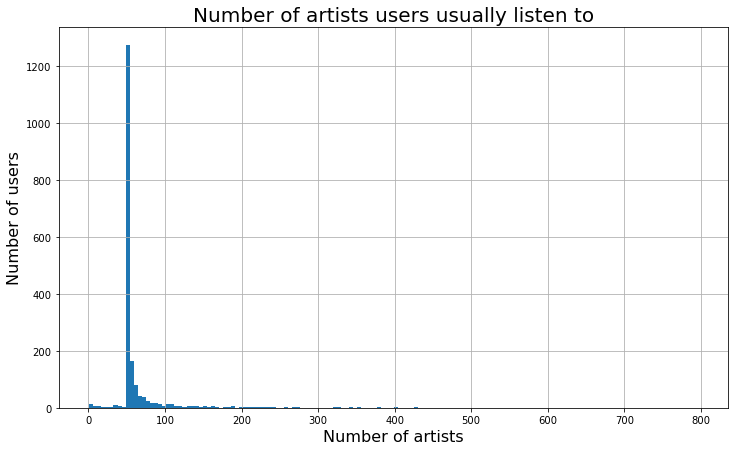

In [46]:
# How many artists do users usually listen to?
fig, ax = plt.subplots(figsize=(12, 7))
final.groupby('user_id')['artist_id'].nunique().hist(bins=150,ax=ax)
plt.title("Number of artists users usually listen to", fontsize=20)
plt.xlabel("Number of artists", fontsize=16)
plt.ylabel("Number of users", fontsize=16)
plt.show()


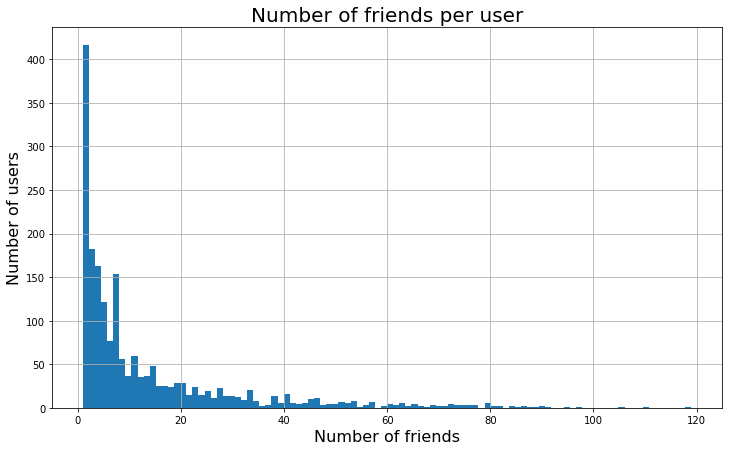

In [45]:
# How many friends do users have?
fig, ax = plt.subplots(figsize=(12, 7))
final.groupby('user_id')['friend_id'].nunique().hist(bins=100, ax=ax)
plt.title("Number of friends per user", fontsize=20)
plt.xlabel("Number of friends", fontsize=16)
plt.ylabel("Number of users", fontsize=16)
plt.show()


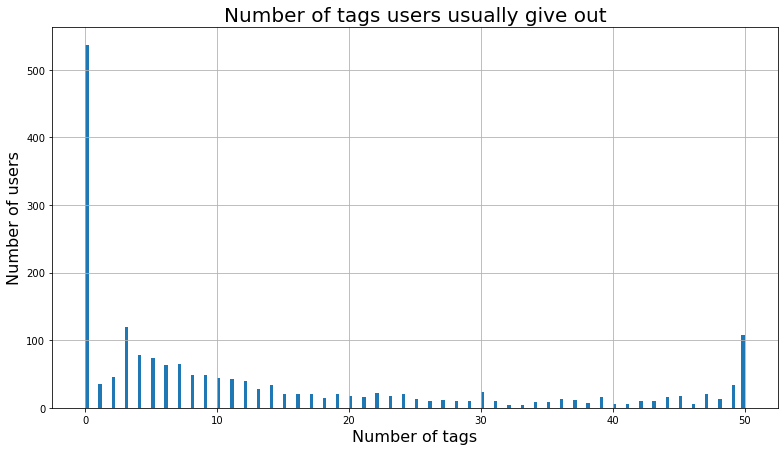

In [57]:
# How many tags do users usually give out? 
fig, ax = plt.subplots(figsize=(13, 7))
final.groupby('user_id')['tag_id'].nunique().hist(bins=200,ax=ax)
plt.title("Number of tags users usually give out", fontsize=20)
plt.xlabel("Number of tags", fontsize=16)
plt.ylabel("Number of users", fontsize=16)
plt.show()

In [97]:
# We can see most users do not give out any tags. 
# For those who do, what are the most popular tags?
print(final.drop_duplicates(['tag_id','user_id']).groupby('tag_value')['user_id'].count().nlargest(20))

tag_value
rock                 484
pop                  414
alternative          380
electronic           354
female vocalists     315
                    ... 
metal                175
ambient              173
singer-songwriter    159
folk                 144
instrumental         140
Name: user_id, Length: 20, dtype: int64


### Artists

It is also useful to look at information about the artists, and tags from their perspective.

In [119]:
artists.describe()

,artist_id,name
count,17632,17632
unique,17632,17632
top,1,MALICE MIZER
freq,1,1


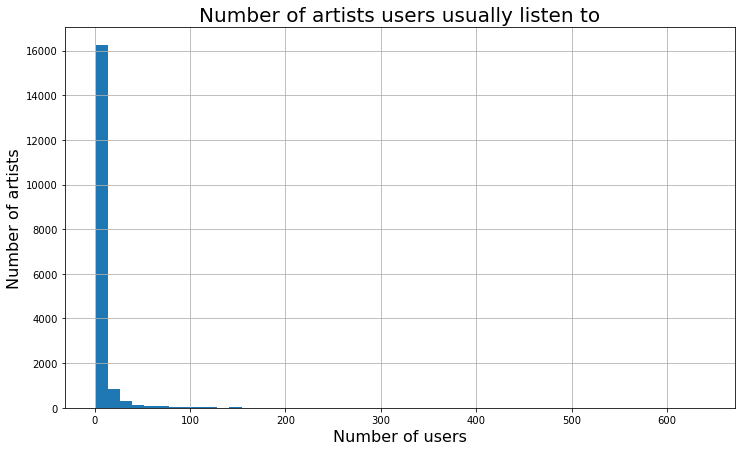

In [41]:
# How many users listen to a specific artist?
fig, ax = plt.subplots(figsize=(12, 7))
final.groupby('artist_id')['user_id'].nunique().hist(bins=50,ax=ax)
plt.title("Number of artists users usually listen to", fontsize=20)
plt.xlabel("Number of users", fontsize=16)
plt.ylabel("Number of artists", fontsize=16)
plt.show()

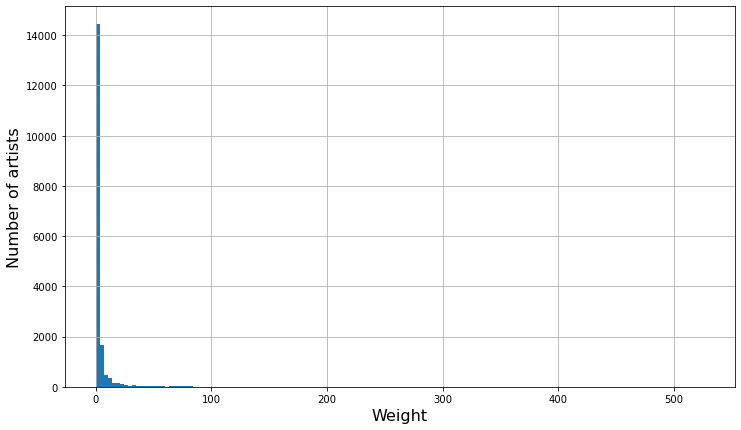

In [96]:
# Number of artists that have bigger weight (users like them more)
fig, ax = plt.subplots(figsize=(12, 7))
final.groupby('artist_id')['weight'].nunique().hist(bins=150, ax=ax)
plt.xlabel("Weight", fontsize=16)
plt.ylabel("Number of artists", fontsize=16)
plt.show()


In [111]:
# Artists with the most 'weight' (most-liked)
print(final.drop_duplicates(['user_id','name','weight']).groupby('name')['weight'].sum().sort_values(ascending=False).head(10))

name
Fair to Midland                                                       999562
Supersilent                                                           999147
KT Tunstall                9989581013261684192585892224031664230716526554...
Raz, Dwa, Trzy                                                       9981399
Flotation Toy Warning                                                   9975
Keyshia Cole               9973589611013736714418113436363141304112412213...
Bleed From Within                                                99647257351
X-Dream                                                              9963106
The Recyclers                                                            996
Kabaret Starszych Panów                                                  996
Name: weight, dtype: object


In [89]:
# Most-listened artists (this is not based on weight, simply a count of all the users that listened to a specific artist)
print(final.drop_duplicates(['name','user_id']).groupby('name')['user_id'].count().nlargest(10))

name
Lady Gaga             611
Britney Spears        522
Rihanna               484
The Beatles           480
Katy Perry            473
Madonna               429
Avril Lavigne         417
Christina Aguilera    407
Muse                  400
Paramore              399
Name: user_id, dtype: int64


In [100]:
# Most popular tags among artists
print(final.drop_duplicates(['tag_id','artist_id']).groupby('tag_value')['artist_id'].count().nlargest(20))

tag_value
rock              1851
alternative       1416
pop               1377
electronic        1374
indie             1230
                  ... 
indie rock         566
electronica        536
male vocalists     522
metal              516
instrumental       513
Name: artist_id, Length: 20, dtype: int64


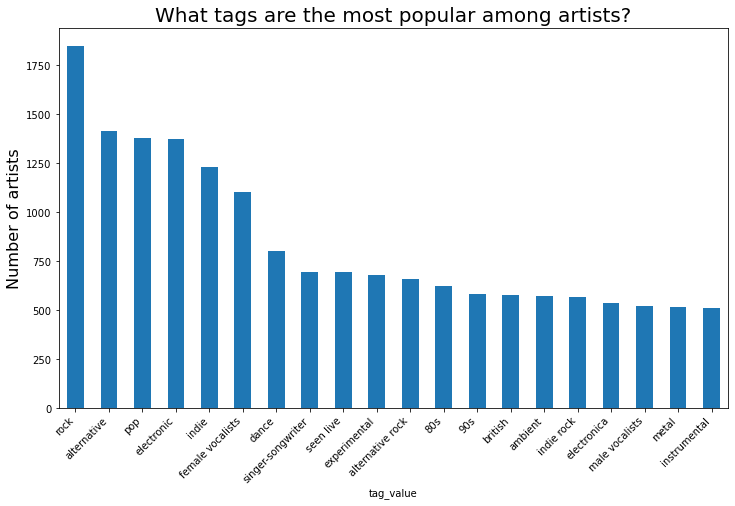

In [108]:
# We can visualise this with a bar plot.
fig, ax = plt.subplots(figsize=(12, 7))
final.drop_duplicates(['tag_value','artist_id']).groupby('tag_value')['artist_id'].count().nlargest(20).plot.bar(ax=ax)
plt.title("What tags are the most popular among artists?", fontsize=20)
plt.ylabel("Number of artists", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.show()


## Recommender system number 1 - most basic

In [61]:
split_value = int(len(ratings) * 0.80)
train_data = ratings[:split_value]
test_data = ratings[split_value:]

In [62]:
# Defining function to get sparse matrix
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.weight, (df.user_id, df.artist_id)))
    return sparse_data


In [63]:
# Getting sparse matrix for train and test data
train_sparse_data = get_user_item_sparse_matrix(train_data)
test_sparse_data = get_user_item_sparse_matrix(test_data)


In [64]:
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))


Global Average Rating: 751.01625217122


In [65]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    no_of_ratings = (sparse_matrix != 0).sum(axis=ax).A1
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i]
                       for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings


In [69]:
# Average rating for a user
average_rating_user = get_average_rating(train_sparse_data, True)
print(average_rating_user[203])

1346.48


In [71]:
# Average rating for an artist
avg_rating_artist = get_average_rating(train_sparse_data, False)
print(avg_rating_artist[5])

519.5555555555555


In [72]:
# User similarity computation
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617, 100)

    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(
            row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar

    return similar_arr


In [74]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)
similar_user_matrix[0]


array([0.12035845, 0.12137938, 0.12143359, 0.12305034, 0.12430902,
       0.12695549, 0.12850693, 0.13200197, 0.13317606, 0.13348926,
       0.1346304 , 0.13490923, 0.13605981, 0.1364896 , 0.13735166,
       0.13749564, 0.13751408, 0.13845567, 0.13945754, 0.13946299,
       0.14024231, 0.143994  , 0.14463049, 0.14478631, 0.14802951,
       0.14822927, 0.14894293, 0.1492594 , 0.15058817, 0.15063087,
       0.15091739, 0.15195481, 0.15433725, 0.15611404, 0.15697728,
       0.15736312, 0.1579289 , 0.1586664 , 0.16152568, 0.16317419,
       0.1635379 , 0.16381253, 0.16443524, 0.16506368, 0.16610937,
       0.16835129, 0.16995312, 0.17322151, 0.17627451, 0.17815813,
       0.18171673, 0.18510854, 0.19033723, 0.19035133, 0.19454561,
       0.19521691, 0.19529926, 0.19761508, 0.19776508, 0.20002143,
       0.20363172, 0.20814997, 0.20965577, 0.21411259, 0.21416641,
       0.2181911 , 0.21878585, 0.22473492, 0.23199828, 0.23329337,
       0.23543029, 0.23561375, 0.2367528 , 0.24050565, 0.24485

In [76]:
# Artist similarity matrix
def compute_artist_similarity_count(sparse_matrix, new_artists, artist_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_artists = new_artists.loc[artist_id][1], similarity[artist_id].count_nonzero()
    return no_of_similar_artists

In [79]:
# If we put in the artist_id here, we will see artists similar to the artist we put in
similar_artists = compute_artist_similarity_count(train_sparse_data, new_artists, 300)
print("Similar Artists = {}".format(similar_artists))

Similar Artists = ('Black Eyed Peas', 1444)


#### Now I will create a sample sparse matrix. New similarity features will be created from this sample sparse matrix.

In [80]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_artists):
    users, artists, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(artists)
    np.random.seed(15)
    user = np.random.choice(uniq_users, no_of_users, replace=False)
    artist = np.random.choice(uniq_movies, no_of_artists, replace=True)
    mask = np.logical_and(np.isin(users, user), np.isin(artists, artist))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], artists[mask])),
                                      shape=(max(user)+1, max(artist)+1))
    return sparse_matrix


In [96]:
test_data['artist_id'].nunique()

6696

In [97]:
train_sample_sparse_matrix = get_sample_sparse_matrix(
    train_sparse_data, 400, 10000)
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 200, 5000)


In [98]:
# Creating similarity features

def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_artists = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_artists, sample_train_ratings = sparse.find(
        sample_sparse_matrix)
    new_features_csv_file = open("new_features.csv", mode="w")

    for user, artist, rating in zip(sample_train_users, sample_train_artists, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(artist)
        similar_arr.append(sample_sparse_matrix.sum() /
                           sample_sparse_matrix.count_nonzero())

        similar_users = cosine_similarity(
            sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        ratings = sample_sparse_matrix[indices, artist].toarray().ravel()
        top_similar_user_ratings = list(ratings[ratings != 0][:5])
        top_similar_user_ratings.extend(
            [global_avg_rating[artist]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)

        similar_artists = cosine_similarity(
            sample_sparse_matrix[:, artist].T, sample_sparse_matrix.T).ravel()
        similar_artists_indices = np.argsort(-similar_artists)[1:]
        similar_artists_ratings = sample_sparse_matrix[user, similar_artists_indices].toarray(
        ).ravel()
        top_similar_artists_ratings = list(
            similar_artists_ratings[similar_artists_ratings != 0][:5])
        top_similar_artists_ratings.extend(
            [global_avg_users[user]] * (5-len(top_similar_artists_ratings)))
        similar_arr.extend(top_similar_artists_ratings)

        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_artists[artist])
        similar_arr.append(rating)

        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")

    new_features_csv_file.close()
    new_features_df = pd.read_csv('new_features.csv', names=["user_id", "artist_id", "global_average", "similar_user_rating1",
                                                             "similar_user_rating2", "similar_user_rating3",
                                                             "similar_user_rating4", "similar_user_rating5",
                                                             "similar_artist_rating1", "similar_artist_rating2",
                                                             "similar_artist_rating3", "similar_artist_rating4",
                                                             "similar_artist_rating5", "user_average",
                                                             "artist_average", "rating"])
    return new_features_df


Generating similar features for the training data

In [99]:
train_new_similar_features = create_new_similar_features(
    train_sample_sparse_matrix)
train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features.head()


,user_id,artist_id,global_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_artist_rating1,similar_artist_rating2,similar_artist_rating3,similar_artist_rating4,similar_artist_rating5,user_average,artist_average,rating
0,272,0,790.701,105.000,99.000,165.000,210.000,86.000,408.182,483.000,483.000,0.000,0.000,0.000,0.000,0.000
1,323,1,790.701,428.000,868.000,182.000,208.000,211.000,213.000,430.000,403.759,1587.333,3466.000,0.000,0.000,0.000
2,933,1,790.701,3466.000,868.000,122.000,205.000,93.000,176.000,296.000,158.176,1587.333,428.000,0.000,0.000,0.000
3,1549,1,790.701,428.000,3466.000,570.000,691.000,700.000,574.000,775.000,834.679,1587.333,868.000,0.000,0.000,0.000
4,679,3,790.701,562.000,209.000,172.000,348.000,172.000,297.143,562.000,562.000,0.000,0.000,0.000,0.000,0.000


Generating similar features for the test data

In [100]:
test_new_similar_features = create_new_similar_features(
    test_sparse_matrix_matrix)
test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()


,user_id,artist_id,global_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_artist_rating1,similar_artist_rating2,similar_artist_rating3,similar_artist_rating4,similar_artist_rating5,user_average,artist_average,rating
0,1677,1,752.311,83.000,277.000,137.000,122.000,128.000,210.000,348.739,122.000,161.000,0.000,0.000,0.000,0.000
1,2064,1,752.311,161.000,116.000,229.000,169.000,96.000,156.000,213.032,122.000,83.000,0.000,0.000,0.000,0.000
2,2098,2,752.311,911.000,232.000,429.000,228.000,305.000,593.880,408.000,408.000,0.000,0.000,0.000,0.000,0.000
3,1708,6,752.311,1752.000,707.000,2481.000,884.000,947.000,127.000,108.000,126.000,92.000,181.000,168.074,926.167,273.000
4,1710,6,752.311,226.000,124.000,884.000,128.000,947.000,473.000,363.000,260.000,1067.000,354.000,1223.870,926.167,264.000


#### Building an ML model

In [101]:
x_train = train_new_similar_features.drop(
    ["user_id", "artist_id", "rating"], axis=1)

x_test = test_new_similar_features.drop(
    ["user_id", "artist_id", "rating"], axis=1)

y_train = train_new_similar_features["rating"]

y_test = test_new_similar_features["rating"]


In [102]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse
 


In [103]:
clf = xgb.XGBRegressor(n_estimators=100, silent=False, n_jobs=10)
clf.fit(x_train, y_train)


[16:22:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [104]:
y_pred_test = clf.predict(x_test)


In [105]:
rmse_test = error_metrics(y_test, y_pred_test)
print("RMSE = {}".format(rmse_test))


RMSE = 3377.3912991011766


Not the best performance, but this was to be expected, as the model is very basic. I will try to improve this with the next two models.

## I will also make a recommender system using k-means clustering.

I am following this tutorial: https://asdkazmi.medium.com/ai-movies-recommendation-system-with-clustering-based-k-means-algorithm-f04467e02fcd

I will scale my 'weight' feature, as the min and max in that column is quite distinct

In [10]:
scaler = MinMaxScaler()
ratings[['weight']] = scaler.fit_transform(ratings[['weight']])
ratings['user_id'] = pd.to_numeric(ratings['user_id'])
ratings['artist_id'] = pd.to_numeric(ratings['artist_id'])

In [11]:
# I will still be using the 'ratings' dataframe
print('Shape of ratings dataset is: ', ratings.shape, '\n')
print('Max values in dataset are \n', ratings.max(), '\n')
print('Min values in dataset are \n', ratings.min(), '\n')


Shape of ratings dataset is:  (92834, 3) 

Max values in dataset are 
 user_id      2098.000
artist_id   18744.000
weight          1.000
dtype: float64 

Min values in dataset are 
 user_id     0.000
artist_id   0.000
weight      0.000
dtype: float64 



In [12]:
# Now I will make the dataset smaller, and include only the relevant artists (after scaling, I will take 0.01 to be the minimum value)
# This is because some users only listen to an artist 1 or 2 times and then move on. I will not include artists like that
users_fav_artists = ratings[ratings.weight > 0.01]
users_fav_artists = users_fav_artists.reset_index(drop=True)


In [13]:
# I will be using the 'users_fav_artists' df now
print('Shape of ratings dataset is: ', users_fav_artists.shape, '\n')
print('Max values in dataset are \n', users_fav_artists.max(), '\n')
print('Min values in dataset are \n', users_fav_artists.min(), '\n')


Shape of ratings dataset is:  (2574, 3) 

Max values in dataset are 
 user_id      2094.000
artist_id   18574.000
weight          1.000
dtype: float64 

Min values in dataset are 
 user_id     0.000
artist_id   6.000
weight      0.010
dtype: float64 



In this section, I will create a sparse matrix which I will use in k-means. For this, let define a function which returns a list of artists for each user from dataset

In [14]:
# The method artistsListForUsers returns a list which will contain strings for each users favorite artists list.
def artistsListForUsers(users, users_data):
    # users = a list of users IDs
    # users_data = a dataframe of users favourite artists or artists that users have listened to
    users_artists_list = []
    for user in users:
        users_artists_list.append(str(list(
            users_data[users_data['user_id'] == user]['artist_id'])).split('[')[1].split(']')[0])
    return users_artists_list


In [15]:
users = np.unique(users_fav_artists['user_id'])
print(users.shape)


(798,)


In [16]:
users_artists_list = artistsListForUsers(users, users_fav_artists)
print('Movies list for', len(users_artists_list), ' users')
print('A list of first 10 users favourite movies: \n', users_artists_list[:10])


Movies list for 798  users
A list of first 10 users favourite movies: 
 ['50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64', '100', '71', '88, 256, 287, 288, 289, 290, 291, 292', '333', '288, 454', '190, 332, 343, 376, 377, 485, 486, 487, 488, 489, 490, 491, 492, 493', '88', '678', '54, 288']


In [17]:
def prepSparseMatrix(list_of_str):
    # list_of_str = A list, which contain strings of users favourite artists separated by comma ",".
    # It will return a sparse matrix and feature names on which sparse matrix is defined
    # i.e. names of artists in the same order as the column of sparse matrix
    cv = CountVectorizer(token_pattern=r'[^\,\ ]+', lowercase=False)
    sparseMatrix = cv.fit_transform(list_of_str)
    return sparseMatrix.toarray(), cv.get_feature_names()


In [18]:
sparseMatrix, feature_names = prepSparseMatrix(users_artists_list)


/Users/julitaswiatek/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
df_sparseMatrix = pd.DataFrame(
    sparseMatrix, index=users, columns=feature_names)
df_sparseMatrix


,100,1000,10015,1008,10107,1012,1013,1018,10184,102,...,9760,977,9795,981,985,9901,992,9931,997,998
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2082,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Checking if the sparse matrix is behaving correctly
first_6_users_SM = users_fav_artists[users_fav_artists['user_id'].isin(users[:6])].sort_values('user_id')
first_6_users_SM.T

,0,14,12,11,10,9,8,13,6,5,...,23,22,21,17,19,18,20,25,26,27
user_id,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,5.000,5.000,5.000,5.000,5.000,5.000,5.000,6.000,9.000,9.000
artist_id,50.000,64.000,62.000,61.000,60.000,59.000,58.000,63.000,56.000,55.000,...,291.000,290.000,289.000,88.000,287.000,256.000,288.000,333.000,288.000,454.000
weight,0.039,0.010,0.011,0.011,0.011,0.012,0.012,0.010,0.017,0.017,...,0.012,0.015,0.018,0.017,0.124,0.015,0.032,0.018,0.011,0.013


In [21]:
df_sparseMatrix.loc[np.unique(first_6_users_SM['user_id']), list(
    map(str, np.unique(first_6_users_SM['artist_id'])))]


,50,51,52,53,54,55,56,57,58,59,...,100,256,287,288,289,290,291,292,333,454
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


My sparse matrix has correct values. I will now move on to creating the clustering model.

For clustering the data, first of all I need to find the optimal number of clusters. For this purpose, I will define an object for elbow method which will contain two functions first for running k-means algorithm for different number of clusters and other for showing plot.

In [64]:

class elbowMethod():
    def __init__(self, sparseMatrix):
        self.sparseMatrix = sparseMatrix
        self.wcss = list()
        self.differences = list()

    def run(self, init, upto, max_iterations=300):
        for i in range(init, upto + 1):
            kmeans = KMeans(n_clusters=i, init='k-means++',
                            max_iter=max_iterations, n_init=10, random_state=0)
            kmeans.fit(sparseMatrix)
            self.wcss.append(kmeans.inertia_)
        self.differences = list()
        for i in range(len(self.wcss)-1):
            self.differences.append(self.wcss[i] - self.wcss[i+1])

    def showPlot(self, boundary=500, upto_cluster=None):
        if upto_cluster is None:
            WCSS = self.wcss
            DIFF = self.differences
        else:
            WCSS = self.wcss[:upto_cluster]
            DIFF = self.differences[:upto_cluster - 1]
        plt.figure(figsize=(15, 6))
        plt.subplot(121).set_title('Elbow Method Graph')
        plt.plot(range(1, len(WCSS) + 1), WCSS)
        plt.grid(b=True)
        plt.subplot(122).set_title(
            'Differences in Each Two Consective Clusters')
        len_differences = len(DIFF)
        X_differences = range(1, len_differences + 1)
        plt.plot(X_differences, DIFF)
        plt.plot(X_differences, np.ones(len_differences)*boundary, 'r')
        plt.plot(X_differences, np.ones(len_differences)*(-boundary), 'r')
        plt.grid()
        plt.show()


elbow_method = elbowMethod(sparseMatrix)


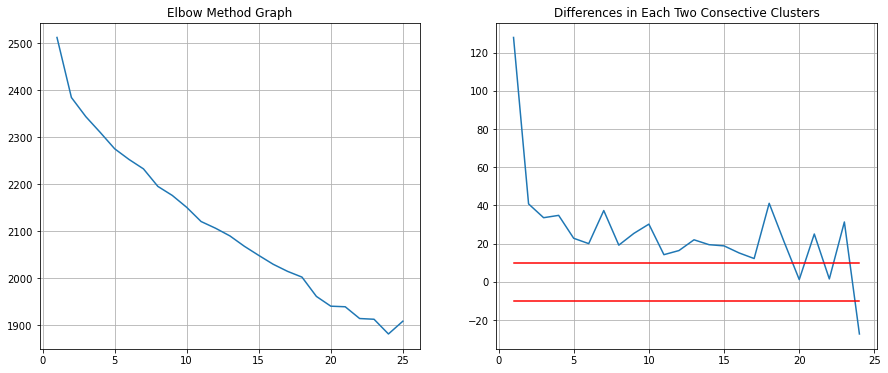

In [46]:
# I will first run the elbow method on 1 to 25 clusters
elbow_method.run(1,25)
elbow_method.showPlot(boundary = 10)

In [65]:
# I will use n_clusters = 19. Creating k-means model
kmeans = KMeans(n_clusters=19, init='k-means++',
                max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(sparseMatrix)


In [66]:
# Creating a dataframe for each cluster number
users_cluster = pd.DataFrame(np.concatenate(
    (users.reshape(-1, 1), clusters.reshape(-1, 1)), axis=1), columns=['user_id', 'Cluster'])
users_cluster.T


,0,1,2,3,4,5,6,7,8,9,...,788,789,790,791,792,793,794,795,796,797
user_id,0,1,2,5,6,9,10,11,15,19,...,2070,2076,2077,2078,2079,2082,2085,2090,2092,2094
Cluster,18,18,5,6,18,1,17,6,18,1,...,1,18,16,5,18,18,14,18,16,18


In [67]:
#Now I’ll define a function which will create a list of DataFrames where each DataFrame will contain the artist_id and the counts for that artist(count: the number of users who have listened to that artist). So, the artist which will have more counts will be of more interest to other users who haven't listened to the artist.
def clustersartists(users_cluster, users_data):
    clusters = list(users_cluster['Cluster'])
    each_cluster_artists = list()
    for i in range(len(np.unique(clusters))):
        users_list = list(
            users_cluster[users_cluster['Cluster'] == i]['user_id'])
        users_artists_list = list()
        for user in users_list:
            users_artists_list.extend(
                list(users_data[users_data['user_id'] == user]['artist_id']))
        users_artists_counts = list()
        users_artists_counts.extend([[artist, users_artists_list.count(
            artist)] for artist in np.unique(users_artists_list)])
        each_cluster_artists.append(pd.DataFrame(users_artists_counts, columns=[
                                   'artist_id', 'Count']).sort_values(by=['Count'], ascending=False).reset_index(drop=True))
    return each_cluster_artists


cluster_artists = clustersartists(users_cluster, users_fav_artists)


In [68]:
cluster_artists[1].T


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
artist_id,288,66,291,54,460,497,287,700,332,465,...,542,541,533,526,523,498,487,485,480,18557
Count,90,19,13,11,7,7,7,7,6,5,...,1,1,1,1,1,1,1,1,1,1


In [70]:
for i in range(19):
    len_users = users_cluster[users_cluster['Cluster'] == i].shape[0]
    print('Users in Cluster ' + str(i) + ' -> ', len_users)


Users in Cluster 0 ->  34
Users in Cluster 1 ->  90
Users in Cluster 2 ->  21
Users in Cluster 3 ->  25
Users in Cluster 4 ->  1
Users in Cluster 5 ->  44
Users in Cluster 6 ->  58
Users in Cluster 7 ->  1
Users in Cluster 8 ->  1
Users in Cluster 9 ->  1
Users in Cluster 10 ->  1
Users in Cluster 11 ->  1
Users in Cluster 12 ->  1
Users in Cluster 13 ->  29
Users in Cluster 14 ->  14
Users in Cluster 15 ->  1
Users in Cluster 16 ->  19
Users in Cluster 17 ->  1
Users in Cluster 18 ->  455


I can see that there are some clusters which contain only 1 user. This will make it difficult to recommend movies. I will move users to clusters which are a bit more 'popular'

In [73]:
def getArtistsOfUser(user_id, users_data):
    return list(users_data[users_data['user_id'] == user_id]['artist_id'])


In [74]:
def fixClusters(clusters_artists_dataframes, users_cluster_dataframe, users_data, smallest_cluster_size=7):
    # clusters_artists_dataframes: will be a list which will contain each dataframes of each cluster movies
    # users_cluster_dataframe: will be a dataframe which contain users IDs and their cluster no.
    # smallest_cluster_size: is a smallest cluster size which we want for a cluster to not remove
    each_cluster_artists = clusters_artists_dataframes.copy()
    users_cluster = users_cluster_dataframe.copy()
    # Let convert dataframe in each_cluster_movies to list with containing only movies IDs
    each_cluster_artists_list = [list(df['artist_id'])
                                for df in each_cluster_artists]
    # First we will prepair a list which containt lists of users in each cluster -> [[Cluster 0 Users], [Cluster 1 Users], ... ,[Cluster N Users]]
    usersInClusters = list()
    total_clusters = len(each_cluster_artists)
    for i in range(total_clusters):
        usersInClusters.append(
            list(users_cluster[users_cluster['Cluster'] == i]['user_id']))
    uncategorizedUsers = list()
    i = 0
    # Now we will remove small clusters and put their users into another list named "uncategorizedUsers"
    # Also when we will remove a cluster, then we have also bring back cluster numbers of users which comes after deleting cluster
    # E.g. if we have deleted cluster 4 then their will be users whose clusters will be 5,6,7,..,N. So, we'll bring back those users cluster number to 4,5,6,...,N-1.
    for j in range(total_clusters):
        if len(usersInClusters[i]) < smallest_cluster_size:
            uncategorizedUsers.extend(usersInClusters[i])
            usersInClusters.pop(i)
            each_cluster_artists.pop(i)
            each_cluster_artists_list.pop(i)
            users_cluster.loc[users_cluster['Cluster'] > i, 'Cluster'] -= 1
            i -= 1
        i += 1
    for user in uncategorizedUsers:
        elemProbability = list()
        user_artists = getArtistsOfUser(user, users_data)
        if len(user_artists) == 0:
            print(user)
        user_missed_artists = list()
        for artists_list in each_cluster_artists_list:
            count = 0
            missed_artists = list()
            for artist in user_artists:
                if artist in artists_list:
                    count += 1
                else:
                    missed_artists.append(artist)
            elemProbability.append(count / len(user_artists))
            user_missed_artists.append(missed_artists)
        user_new_cluster = np.array(elemProbability).argmax()
        users_cluster.loc[users_cluster['user_id']
                          == user, 'Cluster'] = user_new_cluster
        if len(user_missed_artists[user_new_cluster]) > 0:
            each_cluster_artists[user_new_cluster] = each_cluster_artists[user_new_cluster].append(
                [{'artist_id': new_artist, 'Count': 1} for new_artist in user_missed_artists[user_new_cluster]], ignore_index=True)
    return each_cluster_artists, users_cluster


In [75]:
artists_df_fixed, clusters_fixed = fixClusters(cluster_artists, users_cluster, users_fav_artists, smallest_cluster_size = 6)


/var/folders/bs/6183lcc96299bkd5m5mys0vw0000gn/T/ipykernel_7511/2269629936.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  each_cluster_artists[user_new_cluster] = each_cluster_artists[user_new_cluster].append(
/var/folders/bs/6183lcc96299bkd5m5mys0vw0000gn/T/ipykernel_7511/2269629936.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  each_cluster_artists[user_new_cluster] = each_cluster_artists[user_new_cluster].append(
/var/folders/bs/6183lcc96299bkd5m5mys0vw0000gn/T/ipykernel_7511/2269629936.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  each_cluster_artists[user_new_cluster] = each_cluster_artists[user_new_cluster].append(
/var/folders/bs/6183lcc96299bkd5m5mys0vw0000gn/T/ipykernel_7511/2269629936.py:50: Fut

I will check if this operation worked.

In [77]:
j = 0
for i in range(19):
    len_users = users_cluster[users_cluster['Cluster'] == i].shape[0]
    if len_users < 6:
        print('Users in Cluster ' + str(i) + ' -> ', len_users)
        j += 1
print('Total Cluster which we want to remove -> ', j)


Users in Cluster 4 ->  1
Users in Cluster 7 ->  1
Users in Cluster 8 ->  1
Users in Cluster 9 ->  1
Users in Cluster 10 ->  1
Users in Cluster 11 ->  1
Users in Cluster 12 ->  1
Users in Cluster 15 ->  1
Users in Cluster 17 ->  1
Total Cluster which we want to remove ->  9


In [78]:
print('Length of total clusters before fixing is -> ', len(cluster_artists))
print('Max value in users_cluster dataframe column Cluster is -> ',
      users_cluster['Cluster'].max())
print('And dataframe is following')
users_cluster.T


Length of total clusters before fixing is ->  19
Max value in users_cluster dataframe column Cluster is ->  18
And dataframe is following


,0,1,2,3,4,5,6,7,8,9,...,788,789,790,791,792,793,794,795,796,797
user_id,0,1,2,5,6,9,10,11,15,19,...,2070,2076,2077,2078,2079,2082,2085,2090,2092,2094
Cluster,18,18,5,6,18,1,17,6,18,1,...,1,18,16,5,18,18,14,18,16,18


In [79]:
print('Length of total clusters after fixing is -> ', len(artists_df_fixed))
print('Max value in users_cluster dataframe column Cluster is -> ', clusters_fixed['Cluster'].max())
print('And fixed dataframe is following')
clusters_fixed.T 

Length of total clusters after fixing is ->  10
Max value in users_cluster dataframe column Cluster is ->  9
And fixed dataframe is following


,0,1,2,3,4,5,6,7,8,9,...,788,789,790,791,792,793,794,795,796,797
user_id,0,1,2,5,6,9,10,11,15,19,...,2070,2076,2077,2078,2079,2082,2085,2090,2092,2094
Cluster,9,9,4,5,9,1,9,5,9,1,...,1,9,8,4,9,9,7,9,8,9


In [80]:
for i in range(len(artists_df_fixed)):
    len_users = clusters_fixed[clusters_fixed['Cluster'] == i].shape[0]
    print('Users in Cluster ' + str(i) + ' -> ', len_users)


Users in Cluster 0 ->  34
Users in Cluster 1 ->  91
Users in Cluster 2 ->  21
Users in Cluster 3 ->  25
Users in Cluster 4 ->  44
Users in Cluster 5 ->  59
Users in Cluster 6 ->  29
Users in Cluster 7 ->  14
Users in Cluster 8 ->  19
Users in Cluster 9 ->  462


Now we have clusters of appropriate size. I will continue with creating a pipeline for recommending artists to a user.

In [113]:
class userRequestedFor:
    def __init__(self, user_id, users_data):
        self.users_data = users_data.copy()
        self.user_id = user_id
        # Find User Cluster
        users_cluster = clusters_fixed
        self.user_cluster = int(
            users_cluster[users_cluster['user_id'] == self.user_id]['Cluster'])
        # Load User Cluster Artists Dataframe
        self.artists_list = artists_df_fixed
        self.cluster_artists = self.artists_list[self.user_cluster]  # dataframe
        self.cluster_artists_list = list(self.cluster_artists['artist_id'])  # list

    def updatedFavouriteArtistsList(self, new_artist_id):
        if new_artist_id in self.cluster_artists_list:
            self.cluster_artists.loc[self.cluster_artists['artist_id']
                                    == new_artist_id, 'Count'] += 1
        else:
            self.cluster_artists = self.cluster_artists.append(
                [{'artist_id': new_artist_id, 'Count': 1}], ignore_index=True)
        self.cluster_artists.sort_values(
            by=['Count'], ascending=False, inplace=True)
        self.artists_list[self.user_cluster] = self.cluster_artists

    def recommendMostFavouriteArtists(self):
        try:
            user_artists = getArtistsOfUser(self.user_id, self.users_data)
            cluster_artists_list = self.cluster_artists_list.copy()
            for user_artist in user_artists:
                if user_artist in cluster_artists_list:
                    cluster_artists_list.remove(user_artist)
            return [True, cluster_artists_list]
        except KeyError:
            err = "User history does not exist"
            print(err)
            return [False, err]
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            return [False, err]


In [132]:
# Let's check artists which are listened to by user with id 5
user5Artists = getArtistsOfUser(5, users_fav_artists)
for artist in user5Artists:
    name = list(
        new_artists.loc[new_artists['artist_id'] == str(artist)]['name'])
    if name != []:
        print('Artist: ', name[:len(name)-3])
        


Artist:  ['Lady Gaga']
Artist:  ['Mariah Carey']
Artist:  ['Rihanna']
Artist:  ['Britney Spears']
Artist:  ['Jordin Sparks']
Artist:  ['Kelly Clarkson']
Artist:  ['Christina Aguilera']
Artist:  ['Ashlee Simpson']


In [117]:
# Getting recommendations for this user
user5Recommendations = userRequestedFor(5, users_fav_artists).recommendMostFavouriteArtists()[1]
for artist in user5Recommendations[:15]:
    name = list(new_artists.loc[new_artists['artist_id'] == str(artist)]['name'])
    if name != []:
        print('Artist: ', name[:len(name)-3], end = '')
        print()
        
        


Artist:  ['Madonna']
Artist:  ['Ke$ha']
Artist:  ['Katy Perry']
Artist:  ['Miley Cyrus']
Artist:  ['Kylie Minogue']
Artist:  ['Beyoncé']
Artist:  ['Shakira']
Artist:  ['Paramore']
Artist:  ['3OH!3']
Artist:  ['Lindsay Lohan']
Artist:  ['Taylor Swift']
Artist:  ['Ashley Tisdale']
Artist:  ['Wanessa']
Artist:  ['David Archuleta']
Artist:  ['Jeffree Star']


I can see this model is quite good at recommending artists to users who already have a history of artists. Let's see if we can get recommendations for artists without being a user (in the next model)

#### Softmax model

In [419]:
# Changing artist_id types to strings, just in case the system is reading them as int
ratings = ratings.astype({'artist_id':'string','user_id':'string'})

new_artists = new_artists.astype({'artist_id':'string', 'name':'string','tag_id':'string'})

new_artists = new_artists.fillna(value='None')
new_artists


,name,tag_id,artist_id
0,MALICE MIZER,1219,0
1,Diary of Dreams,30,1
2,Carpathian Forest,4,2
3,Moi dix Mois,1,3
4,Bella Morte,575,4
...,...,...,...
17627,Diamanda Galás,None,17627
17628,Aya RL,None,17628
17629,Coptic Rain,None,17629
17630,Oz Alchemist,13,17630


In [420]:
rated_artists = (ratings[["user_id", "artist_id"]]
                .groupby("user_id", as_index=False)
                .aggregate(lambda x: list(x)))
rated_artists.head()

,user_id,artist_id
0,0,"[45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 5..."
1,1,"[95, 96, 97, 98, 99, 100, 101, 102, 103, 104, ..."
2,10,"[66, 183, 185, 224, 282, 294, 327, 338, 371, 3..."
3,100,"[184, 186, 191, 192, 193, 196, 199, 206, 221, ..."
4,1000,"[49, 66, 83, 151, 169, 233, 246, 251, 273, 281..."


In [421]:
#@title Batch generation code (run this cell)

tags_dict = {
    artist: tag
    for artist, tag in zip(new_artists["artist_id"], new_artists["tag_id"])
}
names_dict = {
    artist: name
    for artist, name in zip(new_artists["artist_id"], new_artists["name"])
}

def make_batch(ratings, batch_size):
  """Creates a batch of examples.
  Args:
    ratings: A DataFrame of ratings such that examples["name"] is a list of
      artists rated by a user.
    batch_size: The batch size.
  """
  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values

  artist = []
  name = []
  tag = []
  label = []
  for artist_ids in ratings["artist_id"].values:
    
    artist.append(artist_ids)
    name.append([x for artist_id in artist_ids for x in names_dict[artist_id]])
    tag.append([x for artist_id in artist_ids for x in tags_dict[artist_id]])
    label.append([int(artist_id) for artist_id in artist_ids])
  features = {
      "artist_id": pad(artist, ""),
      "name": pad(name,""),
      "tag_id": pad(tag, ""),
      "label": pad(label, -1)
  }
  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
  return batch


def select_random(x):
  """Selectes a random elements from each row of x."""
  def to_float(x):
    return tf.cast(x, tf.float32)

  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))


In [422]:

def softmax_loss(user_embeddings, artist_embeddings, labels):
  """Returns the cross-entropy loss of the softmax model.
  Args:
    user_embeddings: A tensor of shape [batch_size, embedding_dim].
    artist_embeddings: A tensor of shape [num_artists, embedding_dim].
    labels: A tensor of [batch_size], such that labels[i] is the target label
      for example i.
  Returns:
    The mean cross-entropy loss.
  """
  # Verify that the embddings have compatible dimensions
  user_emb_dim = user_embeddings.shape[1].value
  artist_emb_dim = artist_embeddings.shape[1].value
  if user_emb_dim != artist_emb_dim:
    raise ValueError(
        "The user embedding dimension %d should match the artist embedding "
        "dimension % d" % (user_emb_dim, artist_emb_dim))

  logits = tf.matmul(user_embeddings, artist_embeddings, transpose_b=True)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss


In [423]:
#  CFModel helper class
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [434]:
# Building the model

def build_softmax_model(rated_artists, embedding_cols, hidden_dims):
  """Builds a Softmax model.
  Args:
    rated_artists: DataFrame of traing examples.
    embedding_cols: A dictionary mapping feature names (string) to embedding
      column objects. This will be used in tf.feature_column.input_layer() to
      create the input layer.
    hidden_dims: int list of the dimensions of the hidden layers.
  Returns:
    A CFModel object.
  """
  def create_network(features):
    """Maps input features dictionary to user embeddings.
    Args:
      features: A dictionary of input string tensors.
    Returns:
      outputs: A tensor of shape [batch_size, embedding_dim].
    """
    # Create a bag-of-words embedding for each sparse feature.
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_artists, test_rated_artists = split_dataframe(rated_artists)
  train_batch = make_batch(train_rated_artists, 2000)
  test_batch = make_batch(test_rated_artists, 400)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    artist_embeddings = tf.get_variable(
        "input_layer/artist_id_embedding/embedding_weights")

  test_loss = softmax_loss(
      test_user_embeddings, artist_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, artist_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.matmul(test_user_embeddings,
                            artist_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"artist_id": artist_embeddings}
  return CFModel(embeddings, train_loss, metrics)


2022-12-15 00:39:51.164072: W tensorflow/c/c_api.cc:291] Operation '{name:'model_1/input_layer/tag_id_embedding/tag_id_lookup/hash_table/table_init/LookupTableImportV2' id:504 op device:{requested: '', assigned: ''} def:{{{node model_1/input_layer/tag_id_embedding/tag_id_lookup/hash_table/table_init/LookupTableImportV2}} = LookupTableImportV2[Tin=DT_STRING, Tout=DT_INT64, _has_manual_control_dependencies=true](model_1/input_layer/tag_id_embedding/tag_id_lookup/hash_table/hash_table, model_1/input_layer/tag_id_embedding/tag_id_lookup/Const, model_1/input_layer/tag_id_embedding/tag_id_lookup/Cast)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


 iteration 1800: train_loss=6.507349, test_loss=7.996545, test_precision_at_10=0.007080

({'train_loss': 6.5073495, 'test_loss': 7.9965453},
 {'test_precision_at_10': 0.00708023320377568})

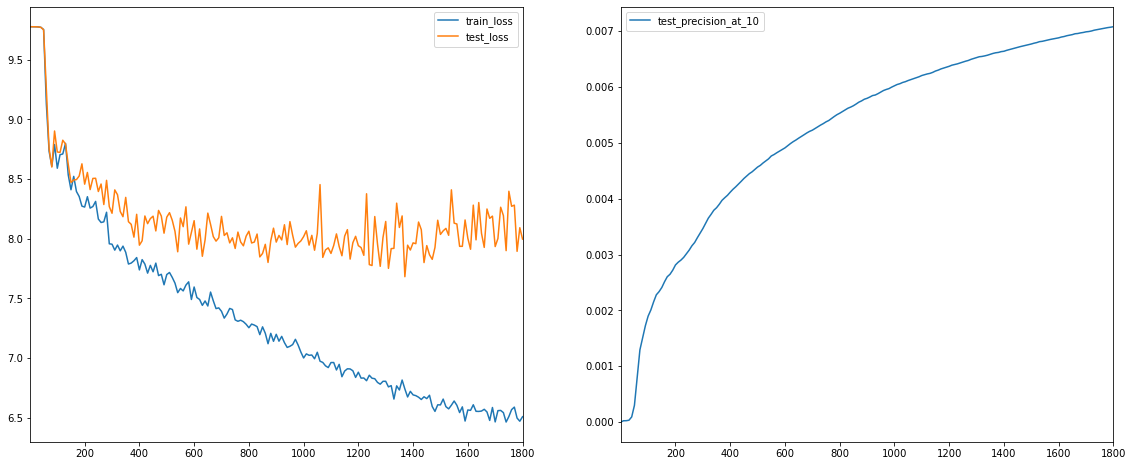

In [435]:
# Create feature embedding columns
def make_embedding_col(key, embedding_dim):
  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(new_artists[key].values)), num_oov_buckets=0)
  return tf.feature_column.embedding_column(
      categorical_column=categorical_col, dimension=embedding_dim,
      # default initializer: trancated normal with stddev=1/sqrt(dimension)
      combiner='mean')


with tf.Graph().as_default():
  softmax_model = build_softmax_model(
      rated_artists,
      embedding_cols=[
          make_embedding_col("artist_id", 35),
          make_embedding_col("name", 2),
          make_embedding_col("tag_id", 3)

      ],
      hidden_dims=[35])

softmax_model.train(
    learning_rate=8., num_iterations=1800, optimizer=tf.train.AdagradOptimizer)


I believe my accuracy could be higher if I tweaked the parameters, the learning rate, number of iterations and number of hidden layers. Due to small computing size (I am working on my own laptop) I couldn't run this model for a very long time, as the code would crash :(. I therefore had to settle for a small training size. This is however my first neural network so I am quite happy with my first attempt.

Below functions for computing scores for neighbours of artists

In [436]:
DOT = 'dot'
COSINE = 'cosine'


def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores
def artists_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids = new_artists[new_artists['name'].str.contains(title_substring)].index.values
  titles = new_artists.iloc[ids]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no artists with name %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  artist_id = ids[0]
  scores = compute_scores(
      model.embeddings["artist_id"][artist_id], model.embeddings["artist_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'names': new_artists['name'],
      'tags': new_artists['tag_id']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))


If the whole code was run, we can put in different artists here and see the recommendations. The couple next cells is me playing with the model and searching for recommendations for different artists.

In [437]:
artists_neighbors(softmax_model, "Michael Jackson", DOT)
artists_neighbors(softmax_model, "Michael Jackson", COSINE)


Nearest neighbors of : Michael Jackson.
[Found more than one matching artist. Other candidates: Michael Jackson & Britney Spears, Michael Jackson & Paul McCartney, Diana Ross, Michael Jackson & Quincy Jones]


,dot score,names,tags
151,10.526,Michael Jackson,24
61,8.948,Madonna,24
469,8.884,Eminem,103
325,8.769,Kanye West,102
289,8.538,Beyoncé,167
283,8.510,Britney Spears,24


Nearest neighbors of : Michael Jackson.
[Found more than one matching artist. Other candidates: Michael Jackson & Britney Spears, Michael Jackson & Paul McCartney, Diana Ross, Michael Jackson & Quincy Jones]


,cosine score,names,tags
151,1.000,Michael Jackson,24
61,0.902,Madonna,24
695,0.890,Shakira,24
57,0.876,Enigma,23
469,0.876,Eminem,103
283,0.873,Britney Spears,24


In [438]:
artists_neighbors(softmax_model, "Taylor Swift", DOT)
artists_neighbors(softmax_model, "Taylor Swift", COSINE)

Nearest neighbors of : Taylor Swift.
[Found more than one matching artist. Other candidates: Taylor Swift & Def Leppard, John Mayer & Taylor Swift]


,dot score,names,tags
338,7.746,Taylor Swift,193
282,7.150,Rihanna,24
289,7.012,Beyoncé,167
285,6.767,Kelly Clarkson,24
327,6.648,Avril Lavigne,24
251,6.554,Mariah Carey,167


Nearest neighbors of : Taylor Swift.
[Found more than one matching artist. Other candidates: Taylor Swift & Def Leppard, John Mayer & Taylor Swift]


,cosine score,names,tags
338,1.000,Taylor Swift,193
185,0.917,OneRepublic,79
285,0.905,Kelly Clarkson,24
336,0.897,Colbie Caillat,130
2957,0.882,Kris Allen,784
3360,0.875,Heidi Montag,39


In [439]:
artists_neighbors(softmax_model, "Red Hot Chili Peppers", DOT)
artists_neighbors(softmax_model, "Red Hot Chili Peppers", COSINE)

Nearest neighbors of : Red Hot Chili Peppers.


,dot score,names,tags
512,8.058,Within Temptation,89
214,7.754,Red Hot Chili Peppers,73
228,7.578,Nirvana,170
469,7.573,Eminem,103
371,7.525,Linkin Park,73
221,7.511,The Beatles,192


Nearest neighbors of : Red Hot Chili Peppers.


,cosine score,names,tags
214,1.000,Red Hot Chili Peppers,73
82,0.931,Gorillaz,18
228,0.922,Nirvana,170
950,0.922,Queen,192
6,0.910,Marilyn Manson,1
221,0.902,The Beatles,192


In [440]:
artists_neighbors(softmax_model, "Kanye West", DOT)
artists_neighbors(softmax_model, "Kanye West", COSINE)


Nearest neighbors of : Kanye West.
[Found more than one matching artist. Other candidates: Kanye West & Jay-Z, Kanye West, Beyoncé & Charlie Wilson, Kanye West feat. Pusha T MpTri.Net, Eminem feat. Drake, Kanye West, Lil Wayne, The-Dream f. Kanye West, Jamie Foxx feat. Kanye West and The-Dream]


,dot score,names,tags
325,9.736,Kanye West,102
512,9.466,Within Temptation,89
151,8.769,Michael Jackson,24
469,8.567,Eminem,103
289,8.482,Beyoncé,167
61,8.382,Madonna,24


Nearest neighbors of : Kanye West.
[Found more than one matching artist. Other candidates: Kanye West & Jay-Z, Kanye West, Beyoncé & Charlie Wilson, Kanye West feat. Pusha T MpTri.Net, Eminem feat. Drake, Kanye West, Lil Wayne, The-Dream f. Kanye West, Jamie Foxx feat. Kanye West and The-Dream]


,cosine score,names,tags
325,1.000,Kanye West,102
695,0.897,Shakira,24
59,0.890,Coldplay,78
372,0.888,Evanescence,73
898,0.886,Timbaland,167
289,0.882,Beyoncé,167
